# The transformer architecture

## Needed libraries

In [9]:
from collections.abc import Iterable
from timeit import default_timer as timer
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import Tensor, nn
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator

# Dataset

In [10]:
from written_numbers_dataset import NumberDataset

## Vocabulary

We first build a vocabulary out of a list of iterators on tokens.
Here the vocabulary is already known. To have a vocabulary object,
we still use `build_vocab_from_iterator` with `[VOCAB]`.

We will also need four different special tokens:

- A token for unknown words
- A padding token
- A token indicating the beginning of a sequence
- A token indicating the end of a sequence

First we choose a dataset

In [19]:
digit = [
    "",
    "UN",
    "DEUX",
    "TROIS",
    "QUATRE",
    "CINQ",
    "SIX",
    "SEPT",
    "HUIT",
    "NEUF",
]

MILLIONS = ["", "MILLE", "MILLION", "MILLIARD"]


def millions(n):
    if n <= 3:
        return MILLIONS[n]
    if n == 4:
        return millions(n - 3) + " MILLIARD"
    if n >= 5:
        return millions(n - 3) + " DE MILLIARD"


r10_19 = [
    "DIX",
    "ONZE",
    "DOUZE",
    "TREIZE",
    "QUATORZE",
    "QUINZE",
    "SEIZE",
    "DIX SEPT",
    "DIX HUIT",
    "DIX NEUF",
]

dizaine = [
    "",
    "",
    "VINGT",
    "TRENTE",
    "QUARANTE",
    "CINQUANTE",
    "SOIXANTE",
    "SOIXANTE",
    "QUATRE VINGT",
    "QUATRE VINGT",
]


def leq99(s, n3):
    d, u = [int(digit) for digit in s]

    # MILLE au lieu de UN MILLE
    if u == 1 and d == 0 and (n3 % 3) == 1:
        return [millions(n3)]

    # Le ET pour VINGT *ET* UN...
    if (u == 1) and 2 <= d <= 7:
        et = "ET"
    else:
        et = ""

    # ONZE, DOUZE,...
    if d == 1 or d == 7 or d == 9:
        rest = r10_19
    else:
        rest = digit

    return [dizaine[d], et, rest[u], millions(n3)]


def leq999(s, n3):
    s = s.zfill(3)
    c = int(s[0])

    if s == "000":
        return []

    if c == 0:
        return leq99(s[1:], n3)

    if c == 1:
        if s[:1] == "00":
            return ["CENT"]
        else:
            return ["CENT"] + leq99(s[1:], n3)

    if 2 <= c <= 9:
        if s[1:] == "00":
            return [digit[c], "CENTS", millions(n3)]
        else:
            return [digit[c], "CENT"] + leq99(s[1:], n3)


def integer_to_token_list(n):
    def written_number0(s, n3):
        if len(s) >= 4:
            return written_number0(s[:-3], n3 + 1) + leq999(s[-3:], n3)
        else:
            return leq999(s, n3)

    w = written_number0(str(n), 0)
    return " ".join(w).split()


class NumberDataset(Dataset):
    import numpy as np
    def __init__(
            self,
            seed=None,
            n_numbers=50000,
    ):
        super().__init__()
        self.seed = seed
        self.n_numbers = n_numbers

        self.vocab_src = list("0123456789")
        self.vocab_tgt = [
            "ET",
            "DE",
            "UN",
            "DEUX",
            "TROIS",
            "QUATRE",
            "CINQ",
            "SIX",
            "SEPT",
            "HUIT",
            "NEUF",
            "DIX",
            "ONZE",
            "DOUZE",
            "TREIZE",
            "QUATORZE",
            "QUINZE",
            "SEIZE",
            "VINGT",
            "TRENTE",
            "QUARANTE",
            "CINQUANTE",
            "SOIXANTE",
            "CENT",
            "CENTS",
            "MILLE",
            "MILLION",
            "MILLIARD",
        ]

        rs = np.random.RandomState(self.seed)

        N = 13
        exponents = rs.uniform(low=2, high=N, size=self.n_numbers)
        self.numbers = (10 ** exponents).astype(np.longlong)

    def __len__(self):
        return self.n_numbers

    def __getitem__(self, i):
        assert(i < self.n_numbers)
        number = self.numbers[i]
        return list(str(number)), integer_to_token_list(number)


In [36]:
# Define a training set and a test set for a dataset.
# Number of sequences generated for the training set
# <answer>
train_set = NumberDataset()
test_set = NumberDataset(n_numbers=1000)
# </answer>
train_set[2]

(['1', '2', '7', '4', '4', '6', '7', '9', '6', '7', '7', '4', '5'],
 ['MILLE',
  'MILLIARD',
  'DEUX',
  'CENT',
  'SOIXANTE',
  'QUATORZE',
  'MILLIARD',
  'QUATRE',
  'CENT',
  'SOIXANTE',
  'SEPT',
  'MILLION',
  'NEUF',
  'CENT',
  'SOIXANTE',
  'SEPT',
  'MILLE',
  'SEPT',
  'CENT',
  'QUARANTE',
  'CINQ'])

In [37]:
train_set.vocab_src

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [50]:
special_tokens = ["<unk>", "<pad>", "<bos>", "<eos>"]
vocab_src = build_vocab_from_iterator([train_set.vocab_src], specials=special_tokens)
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = vocab_src.lookup_indices(special_tokens)
vocab_tgt = build_vocab_from_iterator([train_set.vocab_tgt], specials=special_tokens)

In [55]:
vocab_src(["<bos>"] + ['0','1'] + ["<eos>"])

[2, 4, 5, 3]

You can test the `vocab` object by giving it a list of tokens.

In [ ]:
# vocab([<tokens>,...])

## Collate function

The collate function is needed to convert a list of samples from their raw
form to a Tensor that a Pytorch model can consume. There are two different
tasks:

- numericalizing the sequence: changing each token in its index in the
  vocabulary using the `vocab` object defined earlier
- pad sequence so that they have the same length, see [here][pad]

[pad]: https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html

In [56]:
def collate_fn(batch: List):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:

        # Numericalize list of tokens using `vocab`.
        #
        # - Don't forget to add beginning of sequence and end of sequence tokens
        #   before numericalizing.
        #
        # - Use `torch.LongTensor` instead of `torch.Tensor` because the next
        #   step is an embedding that needs integers for its lookup table.
        # <answer>
        src_tensor = torch.LongTensor(vocab_src(["<bos>"] + src_sample + ["<eos>"]))
        tgt_tensor = torch.LongTensor(vocab_tgt(["<bos>"] + tgt_sample + ["<eos>"]))
        # </answer>

        # Append numericalized sequence to `src_batch` and `tgt_batch`
        src_batch.append(src_tensor)
        tgt_batch.append(tgt_tensor)

    # Turn `src_batch` and `tgt_batch` that are lists of 1-dimensional
    # tensors of varying sizes into tensors with same size with
    # padding. Use `pad_sequence` with padding value to do so.
    #
    # Important notice: by default resulting tensors are of size
    # `max_seq_length` * `batch_size`; the mini-batch size is on the
    # *second dimension*.
    # <answer>
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    # </answer>

    return src_batch, tgt_batch

## Hyperparameters

In [24]:
torch.manual_seed(0)

# Size of source and target vocabulary
SRC_VOCAB_SIZE = len(vocab_src)
TGT_VOCAB_SIZE = len(vocab_tgt)

# Number of epochs
NUM_EPOCHS = 20

# Size of embeddings
EMB_SIZE = 128

# Number of heads for the multihead attention
NHEAD = 1

# Size of hidden layer of FFN
FFN_HID_DIM = 16

# Size of mini-batches
BATCH_SIZE = 1024

# Number of stacked encoder modules
NUM_ENCODER_LAYERS = 1

# Number of stacked decoder modules
NUM_DECODER_LAYERS = 1

## Positional encoding

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float = 0.1, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        # Define Tk/2pi for even k between 0 and `emb_size`. Use
        # `torch.arange`.
        # <answer>
        Tk_over_2pi = 10000 ** (torch.arange(0, emb_size, 2) / emb_size)
        # </answer>

        # Define `t = 0, 1,..., maxlen-1`. Use `torch.arange`.
        # <answer>
        t = torch.arange(maxlen)
        # </answer>

        # Outer product between `t` and `1/Tk_over_2pi` to have a
        # matrix of size `maxlen` * `emb_size // 2`. Use
        # `torch.outer`.
        # <answer>
        outer = torch.outer(t, 1 / Tk_over_2pi)
        # </answer>

        pos_embedding = torch.empty((maxlen, emb_size))

        # Fill `pos_embedding` with either sine or cosine of `outer`.
        # <answer>
        pos_embedding[:, 0::2] = torch.sin(outer)
        pos_embedding[:, 1::2] = torch.cos(outer)
        # </answer>

        # Add fake mini-batch dimension to be able to use broadcasting
        # in `forward` method.
        pos_embedding = pos_embedding.unsqueeze(1)

        self.dropout = nn.Dropout(dropout)

        # Save `pos_embedding` when serializing the model even if it is not a
        # set of parameters
        self.register_buffer("pos_embedding", pos_embedding)

    def forward(self, token_embedding: Tensor):
        # `token_embedding` is of size `seq_length` * `batch_size` *
        # `embedding_size`. Use broadcasting to add the positional embedding
        # that is of size `seq_length` * 1 * `embedding_size`.
        # <answer>
        seq_length = token_embedding.size(0)
        positional_encoding = token_embedding + self.pos_embedding[:seq_length, :]
        # </answer>

        return self.dropout(positional_encoding)

## Transformer model

In [26]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
            self,
            num_encoder_layers: int,
            num_decoder_layers: int,
            emb_size: int,
            nhead: int,
            src_vocab_size: int,
            tgt_vocab_size: int,
            dim_feedforward: int = 512,
            dropout: float = 0.1,
    ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        # Linear layer to compute a score for all tokens from output
        # of transformer
        # <answer>
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        # </answer>

        # Embedding for source vocabulary
        # <answer>
        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
        # </answer>

        # Embedding for target vocabulary
        # <answer>
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        # </answer>

        # Positional encoding layer
        # <answer>
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        # </answer>

    def forward(
            self,
            src: Tensor,
            trg: Tensor,
            src_mask: Tensor,
            tgt_mask: Tensor,
            src_padding_mask: Tensor,
            tgt_padding_mask: Tensor,
            memory_key_padding_mask: Tensor,
    ):
        # Embed `src` and `trg` tensors and add positional embedding.
        # <answer>
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        # </answer>

        outs = self.transformer(
            src_emb,
            tgt_emb,
            src_mask,
            tgt_mask,
            None,
            src_padding_mask,
            tgt_padding_mask,
            memory_key_padding_mask,
        )

        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        # Use the encoder part of the transformer to encode `src`.
        # <answer>
        return self.transformer.encoder(
            self.positional_encoding(self.src_tok_emb(src)), src_mask
        )
        # </answer>

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        # Use the decoder par of the transformer to decode `tgt`
        # <answer>
        return self.transformer.decoder(
            self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
        )
        # </answer>

    def encode_and_attention(self, src: Tensor, src_mask: Tensor):
        """Used at test-time only to retrieve attention matrix."""

        src_pos = self.positional_encoding(self.src_tok_emb(src))
        self_attn = self.transformer.encoder.layers[-1].self_attn
        att = self_attn(src_pos, src_pos, src_pos, attn_mask=src_mask)[1]
        return self.encode(src, src_mask), att

    def decode_and_attention(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        """Used at test-time only to retrieve attention matrix."""

        # Use first decoder layer
        decoder = self.transformer.decoder.layers[0]

        x = self.positional_encoding(self.tgt_tok_emb(tgt))
        x = decoder.norm1(x + decoder._sa_block(x, tgt_mask, None))
        att = decoder.multihead_attn(x, memory, memory, need_weights=True)[1]

        return self.transformer.decoder(x, memory, tgt_mask), att

## Mask function

In [28]:
def create_mask(src: Tensor, tgt: Tensor):
    # Lengths of source and target sequences
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    # Attention mask for the source. As we have no reason to mask input
    # tokens, we use a mask full of False. You can use `torch.full`.
    # <answer>
    src_mask = torch.full((src_seq_len, src_seq_len), False)
    # </answer>

    # Attention mask for the target. To prevent a token from receiving
    # attention from future ones, we use a mask as defined in the lecture
    # (matrix `M`). You can use `torch.triu` and `torch.full` or directly
    # use the static function `generate_square_subsequent_mask` from the
    # `Transformer` class.
    # <answer>
    tgt_mask = Transformer.generate_square_subsequent_mask(tgt_seq_len)
    # </answer>

    # Boolean masks identifying tokens that have been padded with
    # `PAD_IDX`. Use `src` and `tgt` to create them. Don't forget to
    # ajust the size since both `src` and `tgt` are of size
    # `batch_size` * `seq_len` and the transformer object needs masks
    # of size `seq_len` * `batch_size`.
    # <answer>
    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    # </answer>

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Training function

In [29]:
def train_epoch(model: nn.Module, dataset: Dataset, optimizer: Optimizer):
    # Training mode
    model.train()

    # Set loss function to use. Don't forget to tell the loss function to
    # ignore entries that are padded.
    # <answer>
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    # </answer>

    # Turn `dataset` into an iterable on mini-batches using `DataLoader`.
    # <answer>
    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    # </answer>

    losses = 0
    for src, tgt in train_dataloader:
        # Select all but the last element of each sequence in `tgt`
        # <answer>
        tgt_input = tgt[:-1, :]
        # </answer>

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input
        )

        scores = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask,
        )

        # Resetting gradients
        optimizer.zero_grad()

        # Select all but the first element of each sequence in `tgt`
        # <answer>
        tgt_out = tgt[1:, :]
        # </answer>

        # Permute dimensions before cross-entropy loss:
        #
        # - `logits` is `seq_length` * `batch_size` * `vocab_size` and should be
        #   `batch_size` * `vocab_size` * `seq_length`
        # - `tgt_out` is `seq_length` * `batch_size` and should be
        #   `batch_size` * `seq_length`
        # <answer>
        loss = loss_fn(scores.permute([1, 2, 0]), tgt_out.permute([1, 0]))
        # </answer>

        # Back-propagation through loss function
        loss.backward()

        # Gradient descent update
        optimizer.step()

        losses += loss.item()

    return losses / len(dataset)

## Evaluation function

In [30]:
def evaluate(model: nn.Module, val_dataset: Dataset):
    model.eval()

    # Set loss function to use. Don't forget to tell the loss function to
    # ignore entries that are padded.
    # <answer>
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    # </answer>

    # Turn dataset into an iterable on batches
    # <answer>
    val_dataloader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn
    )
    # </answer>

    losses = 0
    for src, tgt in val_dataloader:
        # Select all but the last element of each sequence in `tgt`
        # <answer>
        tgt_input = tgt[:-1, :]
        # </answer>

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input
        )

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask,
        )

        # Select all but the first element of each sequence in `tgt`
        # <answer>
        tgt_out = tgt[1:, :]
        # </answer>

        # Permute dimensions for cross-entropy loss:
        #
        # - `logits` is `seq_length` * `batch_size` * `vocab_size` and should be
        #   `batch_size` * `vocab_size` * `seq_length`
        # - `tgt_out` is `seq_length` * `batch_size` and should be
        #   `batch_size` * `seq_length`
        # <answer>
        loss = loss_fn(logits.permute([1, 2, 0]), tgt_out.permute([1, 0]))
        # </answer>

        losses += loss.item()

    return losses / len(val_dataset)

In [31]:
## Learning loop

transformer = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    FFN_HID_DIM,
)

optimizer = Adam(transformer.parameters(), lr=0.001)

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, train_set, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer, test_set)
    print(
        (
            f"Epoch: {epoch}, Train loss: {train_loss:.5f}, Val loss: {val_loss:.5f}, "
            f"Epoch time = {(end_time - start_time):.3f}s"
        )
    )

D:\Programming\Conda_envs\ML\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
D:\Programming\Conda_envs\ML\Lib\site-packages\torch\nn\functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 0.00231, Val loss: 0.00156, Epoch time = 11.257s
Epoch: 2, Train loss: 0.00141, Val loss: 0.00087, Epoch time = 10.620s
Epoch: 3, Train loss: 0.00106, Val loss: 0.00064, Epoch time = 10.930s
Epoch: 4, Train loss: 0.00090, Val loss: 0.00045, Epoch time = 11.146s
Epoch: 5, Train loss: 0.00076, Val loss: 0.00034, Epoch time = 23.764s
Epoch: 6, Train loss: 0.00068, Val loss: 0.00028, Epoch time = 16.989s
Epoch: 7, Train loss: 0.00064, Val loss: 0.00024, Epoch time = 10.875s
Epoch: 8, Train loss: 0.00061, Val loss: 0.00022, Epoch time = 10.390s
Epoch: 9, Train loss: 0.00058, Val loss: 0.00021, Epoch time = 10.610s
Epoch: 10, Train loss: 0.00057, Val loss: 0.00020, Epoch time = 10.860s
Epoch: 11, Train loss: 0.00055, Val loss: 0.00019, Epoch time = 10.685s
Epoch: 12, Train loss: 0.00054, Val loss: 0.00018, Epoch time = 12.781s
Epoch: 13, Train loss: 0.00052, Val loss: 0.00017, Epoch time = 13.944s
Epoch: 14, Train loss: 0.00051, Val loss: 0.00016, Epoch time = 10.520s
E

## Helpers functions

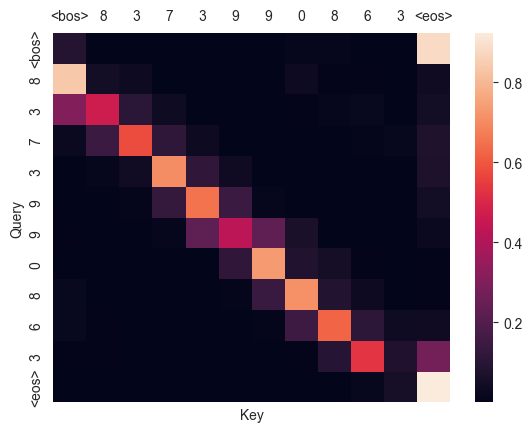

In [58]:
def greedy_decode(model, src, src_mask, start_symbol_idx):
    """Autoregressive decoding of `src` starting with `start_symbol_idx`."""

    memory, att = model.encode_and_attention(src, src_mask)
    ys = torch.LongTensor([[start_symbol_idx]])
    maxlen = 100

    for i in range(maxlen):
        tgt_mask = Transformer.generate_square_subsequent_mask(ys.size(0))

        # Decode `ys`. `out` is of size `curr_len` * 1 * `vocab_size`
        out = model.decode(ys, memory, tgt_mask)

        # Select encoding of last token
        enc = out[-1, 0, :]

        # Get a set of scores on vocabulary
        dist = model.generator(enc)

        # Get index of maximum
        idx = torch.argmax(dist).item()

        # Add predicted index to `ys`
        ys = torch.cat((ys, torch.LongTensor([[idx]])))

        if idx == EOS_IDX:
            break
    return ys, att


def translate(model: torch.nn.Module, src_sentence: Iterable):
    """Translate sequence `src_sentence` with `model`."""

    model.eval()

    # Numericalize source
    src_tensor = torch.LongTensor(vocab_src(["<bos>"] + list(src_sentence) + ["<eos>"]))

    # Fake a minibatch of size one
    src = src_tensor.unsqueeze(-1)

    # No mask for source sequence
    seq_length = src.size(0)
    src_mask = torch.full((seq_length, seq_length), False)

    # Translate `src`
    tgt_tokens, att = greedy_decode(model, src, src_mask, BOS_IDX)

    tgt_tokens = tgt_tokens.flatten().numpy()
    att = att.detach().squeeze().numpy()
    return " ".join(vocab_tgt.lookup_tokens(list(tgt_tokens))), att


def plot_encoder_attention_matrix(model, src):
    """Plot heatmap of encoder's attention matrix."""

    model.eval()

    # Numericalize source
    src_delim = ["<bos>"] + list(src) + ["<eos>"]
    src_tensor = torch.LongTensor(vocab_src(src_delim))

    # Fake a minibatch of size one
    src = src_tensor.unsqueeze(-1)

    # No mask for source sequence
    seq_length = src.size(0)
    src_mask = torch.full((seq_length, seq_length), False)

    # Translate `src`
    memory, att = model.encode_and_attention(src, src_mask)

    ax = sns.heatmap(
        att.detach().squeeze().numpy(),
        xticklabels=src_delim,
        yticklabels=src_delim,
    )
    ax.set(xlabel='Key', ylabel='Query')

    ax.tick_params(
        axis="both",
        which="major",
        labelsize=10,
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
    )

def plot_decoder_attention_matrix(model, src, tgt):
    """Plot heatmap of decoder's cross-attention matrix."""

    model.eval()

    # Numericalize source and target
    src_delim = ["<bos>"] + list(src) + ["<eos>"]
    src_tensor = torch.LongTensor(vocab_src(src_delim))
    tgt_delim = ["<bos>"] + list(tgt) + ["<eos>"]
    tgt_tensor = torch.LongTensor(vocab_tgt(tgt_delim))

    # Fake a minibatch of size one
    src = src_tensor.unsqueeze(-1)
    tgt = tgt_tensor.unsqueeze(-1)

    # No mask for source sequence and triangular mask to target
    seq_length = src.size(0)
    src_mask = torch.full((seq_length, seq_length), False)
    tgt_mask = Transformer.generate_square_subsequent_mask(tgt.size(0))

    # Encode `src`
    memory = model.encode(src, src_mask)

    # Retrieve cross-attention matrix
    _, att = model.decode_and_attention(tgt, memory, tgt_mask)

    ax = sns.heatmap(
        att.detach().squeeze().numpy(),
        xticklabels=src_delim,
        yticklabels=tgt_delim,
    )
    ax.set(xlabel='Key', ylabel='Query')

    ax.tick_params(
        axis="both",
        which="major",
        labelsize=10,
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
    )


src, tgt = test_set[0]
pred, att = translate(transformer, src)

plot_encoder_attention_matrix(transformer, src)
plt.show()

# plot_decoder_attention_matrix(transformer, src, tgt)
# plt.show()